In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from Utils import plot_graphs, plot_attention_heatmaps
import wandb
import pandas as pd
from SequenceLearning import *

In [9]:
# Model hyperparameters (for both attention and vanilla models)
input_size_encoder = english_char_count
input_size_decoder = target_char_count
output_size = target_char_count
MAX_LEN = 35

# Without Attention

In [10]:
batch_size = 32
train = data.load_data("train", batch_size)
valid = data.load_data("valid", batch_size)
test = data.load_data(  "test", batch_size)

## Sweep

In [ ]:
wandb.login()
sweep_config = {
    "method": 'bayes',
    "metric": {
    'name': 'accuracy',
    'goal': 'maximize'
    },
    'parameters' :{
        "num_epochs" : {"min": 7, "max": 18}, 
        "learning_rate" : {"values": [1e-2, 1e-3]},
        "encoder_layers": {"values": [1,2,3]},
        "decoder_layers": {"values": [1,2,3]},
        "hidden_size" : {"values": [64, 128, 256]},
        "rnn" : {"values" : ["LSTM", "GRU", "RNN"]},
        "bi_directional" : {"values": [True, False]},
        "dropout" : {"values": [0.2, 0.3]},
        "embedding_size" : {"values" : [32, 64, 128, 256]}}
}

def tune_rnn():
   """A utility function for performing the sweep"""
   wandb.init()

   if(wandb.config.rnn == "LSTM"):
      rnn = nn.LSTM
   if(wandb.config.rnn == "GRU"):
      rnn = nn.GRU
   if(wandb.config.rnn == "RNN"):
      rnn = nn.RNN

   enc = Encoder(english_char_count, wandb.config.embedding_size, wandb.config.hidden_size, 
               num_layers=wandb.config.encoder_layers, 
               bi_dir=wandb.config.bi_directional,
               p=wandb.config.dropout,
               rnn_class=rnn).to(device)

   dec = Decoder(target_char_count, wandb.config.embedding_size, wandb.config.hidden_size, target_char_count, 
               num_layers=wandb.config.decoder_layers, 
               bi_dir=wandb.config.bi_directional, 
               p =wandb.config.dropout,
               rnn_class=rnn).to(device)

   mod = Seq2Seq(enc, dec).to(device)

   optimizer = optim.Adam(mod.parameters(), lr=wandb.config.learning_rate)
   tr_loss, val_loss, tr_acc, val_acc = mod.learn(train, valid, wandb.config.num_epochs, optimizer)


   name = f"{wandb.config.encoder_layers}_enc_{wandb.config.decoder_layers}_dec_{wandb.config.hidden_size}_hs_"
   if(wandb.config.bi_directional == True):
      name += "bidir_"
   if(dec.used_attn == True):
      name += "attn_"
   if(len(tr_loss) != wandb.config.num_epochs):
      name += "early_stop"
   wandb.run.name = name

   for i in range(len(tr_loss)):
      wandb.log({"tr_loss":tr_loss[i],
                  "tr_acc" : tr_acc[i],
                  "val_loss" : val_loss[i],
                  "val_acc" : val_acc[i],
                  "epoch":(i+1)})

      wandb.log({"accuracy": val_acc[-1]})

sweep_id=wandb.sweep(sweep_config,project="CS6910_Assignment_3")
wandb.agent(sweep_id,function=tune_rnn)
wandb.finish()

## Best Model

In [11]:
num_epochs = 9
learning_rate = 0.001

embedding_size = 32
encoder_layers = 3
decoder_layers = 2
enc_dropout = 0.3
dec_dropout = 0.3
hidden_size = 256
bi_directional = True
rnn = nn.LSTM

In [12]:
enc = Encoder(english_char_count, 
              embedding_size, hidden_size, 
              num_layers=encoder_layers, 
              bi_dir=bi_directional,
              p=enc_dropout,
              rnn_class=rnn).to(device)

dec = Decoder(target_char_count, embedding_size, hidden_size, target_char_count, 
              num_layers=decoder_layers, 
              bi_dir=bi_directional, 
              p = dec_dropout,
              rnn_class=rnn).to(device)

model = Seq2Seq(enc, dec).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

[Epoch   1/9] 	 Loss: 1.364	 Acc: 15.68 	 Val Loss: 0.962	 Val Acc: 48.78


[Epoch   2/9] 	 Loss: 0.505	 Acc: 54.74 	 Val Loss: 0.903	 Val Acc: 56.81


[Epoch   3/9] 	 Loss: 0.428	 Acc: 64.00 	 Val Loss: 0.906	 Val Acc: 57.84


[Epoch   4/9] 	 Loss: 0.391	 Acc: 68.53 	 Val Loss: 0.887	 Val Acc: 59.42


[Epoch   5/9] 	 Loss: 0.369	 Acc: 71.43 	 Val Loss: 0.879	 Val Acc: 60.67


[Epoch   6/9] 	 Loss: 0.395	 Acc: 71.71 	 Val Loss: 0.843	 Val Acc: 60.08


[Epoch   7/9] 	 Loss: 0.368	 Acc: 73.25 	 Val Loss: 0.860	 Val Acc: 59.86


[Epoch   8/9] 	 Loss: 0.353	 Acc: 74.86 	 Val Loss: 0.885	 Val Acc: 60.08


[Epoch   9/9] 	 Loss: 0.336	 Acc: 76.38 	 Val Loss: 0.921	 Val Acc: 60.74


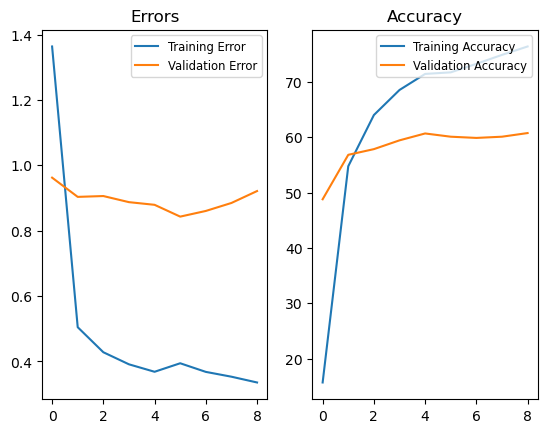

In [ ]:
loss, val_loss, acc, val_acc = model.learn(train, valid, num_epochs, optimizer)
fig = plot_graphs(loss, val_loss, acc, val_acc)

## Testing

In [ ]:
test_loss, test_acc = model.calc_evaluation_metrics(test, path_to_store_predictions="vanilla_results.csv")
print(f"Test dataset loss: {test_loss:.2f} \nAccuracy: {test_acc}")

Test dataset loss: 1.23 
Accuracy: 50.1953125


## Correct vs Incorrect Predictions

In [19]:
res_df = pd.read_csv("predictions_vanilla/results.csv")
correct_predictions_df = res_df[res_df['PredictionStatus']=='correct']
correct_predictions_df.head(10)

,Source,Target,Predicted,PredictionStatus
1,paantavarkalai,பாண்டவர்களை,பாண்டவர்களை,correct
4,neettik,நீட்டிக்,நீட்டிக்,correct
6,kuuttankalukku,கூட்டங்களுக்கு,கூட்டங்களுக்கு,correct
7,prabu,பிரபு,பிரபு,correct
9,adangkiyulla,அடங்கியுள்ள,அடங்கியுள்ள,correct
11,kuriththullaargal,குறித்துள்ளார்கள்,குறித்துள்ளார்கள்,correct
13,paguthiyirukkiradhu,பகுதியிருக்கிறது,பகுதியிருக்கிறது,correct
15,jose,ஜோஸ்,ஜோஸ்,correct
16,varikalai,வரிகளை,வரிகளை,correct
17,uruthiyudan,உறுதியுடன்,உறுதியுடன்,correct


In [20]:
incorrect_predictions_df = res_df[res_df['PredictionStatus']=='wrong']
incorrect_predictions_df.head(20)

,Source,Target,Predicted,PredictionStatus
0,rane,ராணே,ரானே,wrong
2,hairis,ஹாரிஸ்,ஹைரிஸ்,wrong
3,airoappiya,அய்ரோப்பிய,ஐரோப்பிய,wrong
5,navas,நவாஸ்,நவஸ்,wrong
8,pricol,ப்ரிகால்,பிரிக்க்ல்,wrong
10,winter,வின்டர்,விண்டர்,wrong
12,vineedh,வினீத்,விநீத்,wrong
14,pakthargal,பக்தா்கள்,பக்தர்கள்,wrong
18,varalaaratra,வரலாறற்ற,வரலாறத்ற,wrong
22,saalukkiyar,சாளுக்கியர்,சாலுக்கியர்,wrong


# With Attention

In [15]:
batch_size = 128
train = data.load_data("train", batch_size, padding_upper_bound=MAX_LEN)
train = data.load_data("train", batch_size, padding_upper_bound=MAX_LEN)
valid = data.load_data("valid", batch_size, padding_upper_bound=MAX_LEN)
test = data.load_data(  "test", batch_size, padding_upper_bound=MAX_LEN)

## Sweep

In [ ]:
wandb.login()
sweep_config = {
    "method": 'bayes',
    "metric": {
    'name': 'accuracy',
    'goal': 'maximize'
    },
    'parameters' :{
        "num_epochs" : {"min": 7, "max": 20}, 
        "learning_rate" : {"values": [1e-2, 1e-3]},
        "encoder_layers": {"values": [1,2,3]},
        "decoder_layers": {"values": [1,2,3]},
        "hidden_size" : {"values": [64, 128, 256]},
        "rnn" : {"values" : ["LSTM", "GRU", "RNN"]},
        "bi_directional" : {"values": [True, False]},
        "dropout" : {"values": [0.2, 0.3]},
        "embedding_size" : {"values" : [32, 64, 128, 256]}}
}

def tune_rnn():
    """A utility function for performing the sweep"""
    wandb.init()

    if(wandb.config.rnn == "LSTM"):
        rnn = nn.LSTM
    if(wandb.config.rnn == "GRU"):
        rnn = nn.GRU
    if(wandb.config.rnn == "RNN"):
        rnn = nn.RNN

    enc = Encoder(english_char_count, wandb.config.embedding_size, wandb.config.hidden_size, 
               num_layers=wandb.config.encoder_layers, 
               bi_dir=wandb.config.bi_directional,
               p=wandb.config.dropout,
               rnn_class=rnn).to(device)

    dec = AttnDecoder(wandb.config.embedding_size, wandb.config.hidden_size, output_size=target_char_count, 
                         num_layers=wandb.config.decoder_layers,
                         dropout_p = wandb.config.dropout, 
                         bi_dir = wandb.config.bi_directional,
                         rnn_class= rnn,
                         max_length=MAX_LEN).to(device)

    mod = Seq2Seq(enc, dec).to(device)

    optimizer = optim.Adam(mod.parameters(), lr=wandb.config.learning_rate)
    tr_loss, val_loss, tr_acc, val_acc = mod.learn(train, valid, wandb.config.num_epochs, optimizer)


    name = f"{wandb.config.encoder_layers}_enc_{wandb.config.decoder_layers}_dec_{wandb.config.hidden_size}_hs_"
    if(wandb.config.bi_directional == True):
        name += "bidir_"
    if(dec.used_attn == True):
        name += "attn_"
    if(len(tr_loss) != wandb.config.num_epochs):
        name += "early_stop"
    wandb.run.name = name

    for i in range(len(tr_loss)):
        wandb.log({"tr_loss":tr_loss[i],
                  "tr_acc" : tr_acc[i],
                  "val_loss" : val_loss[i],
                  "val_acc" : val_acc[i],
                  "epoch":(i+1)})

        wandb.log({"accuracy": val_acc[-1]})

sweep_id=wandb.sweep(sweep_config,project="CS6910_Assignment_3_Attn")
wandb.agent(sweep_id,function=tune_rnn)
wandb.finish()

## Best Model

In [16]:
num_epochs = 16
learning_rate = 0.001

embedding_size = 128
encoder_layers = 3
decoder_layers = 2
enc_dropout = 0.2
dec_dropout = 0.2
hidden_size = 256
bi_directional = True
rnn = nn.LSTM

In [17]:
enc = Encoder(english_char_count, 
              embedding_size, hidden_size, 
              num_layers=encoder_layers, 
              bi_dir=bi_directional,
              p=enc_dropout,
              rnn_class=rnn).to(device)

dec = AttnDecoder(embedding_size, hidden_size, output_size=target_char_count, 
                     num_layers=decoder_layers,
                     bi_dir = bi_directional,
                          rnn_class= rnn,
                     max_length=MAX_LEN).to(device)

attn_model = Seq2Seq(enc, dec).to(device)

optimizer = optim.Adam(attn_model.parameters(), lr=learning_rate)

[Epoch   1/16] 	 Loss: 1.616	 Acc: 8.16 	 Val Loss: 1.053	 Val Acc: 39.77


[Epoch   2/16] 	 Loss: 0.574	 Acc: 47.91 	 Val Loss: 0.884	 Val Acc: 51.00


[Epoch   3/16] 	 Loss: 0.446	 Acc: 61.78 	 Val Loss: 0.853	 Val Acc: 54.03


[Epoch   4/16] 	 Loss: 0.399	 Acc: 67.35 	 Val Loss: 0.843	 Val Acc: 57.13


[Epoch   5/16] 	 Loss: 0.365	 Acc: 71.03 	 Val Loss: 0.869	 Val Acc: 57.50


[Epoch   6/16] 	 Loss: 0.349	 Acc: 73.63 	 Val Loss: 0.841	 Val Acc: 58.18


[Epoch   7/16] 	 Loss: 0.327	 Acc: 76.38 	 Val Loss: 0.876	 Val Acc: 58.45


[Epoch   8/16] 	 Loss: 0.318	 Acc: 78.02 	 Val Loss: 0.903	 Val Acc: 59.45


[Epoch   9/16] 	 Loss: 0.351	 Acc: 77.51 	 Val Loss: 0.867	 Val Acc: 58.30


[Epoch  10/16] 	 Loss: 0.329	 Acc: 79.57 	 Val Loss: 0.879	 Val Acc: 60.06


[Epoch  11/16] 	 Loss: 0.313	 Acc: 81.55 	 Val Loss: 0.899	 Val Acc: 59.86


[Epoch  12/16] 	 Loss: 0.301	 Acc: 82.98 	 Val Loss: 0.919	 Val Acc: 61.33


[Epoch  13/16] 	 Loss: 0.291	 Acc: 84.33 	 Val Loss: 0.944	 Val Acc: 60.38


[Epoch  14/16] 	 Loss: 0.284	 Acc: 85.38 	 Val Loss: 0.937	 Val Acc: 59.62


[Epoch  15/16] 	 Loss: 0.279	 Acc: 86.18 	 Val Loss: 0.968	 Val Acc: 61.28


[Epoch  16/16] 	 Loss: 0.271	 Acc: 87.38 	 Val Loss: 0.978	 Val Acc: 61.43


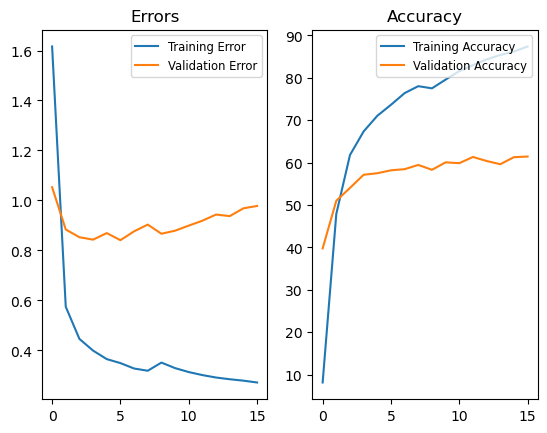

In [18]:
loss, val_loss, acc, val_acc = attn_model.learn(train, valid, num_epochs, optimizer)
fig = plot_graphs(loss, val_loss, acc, val_acc)

## Visualizing attention heatmaps

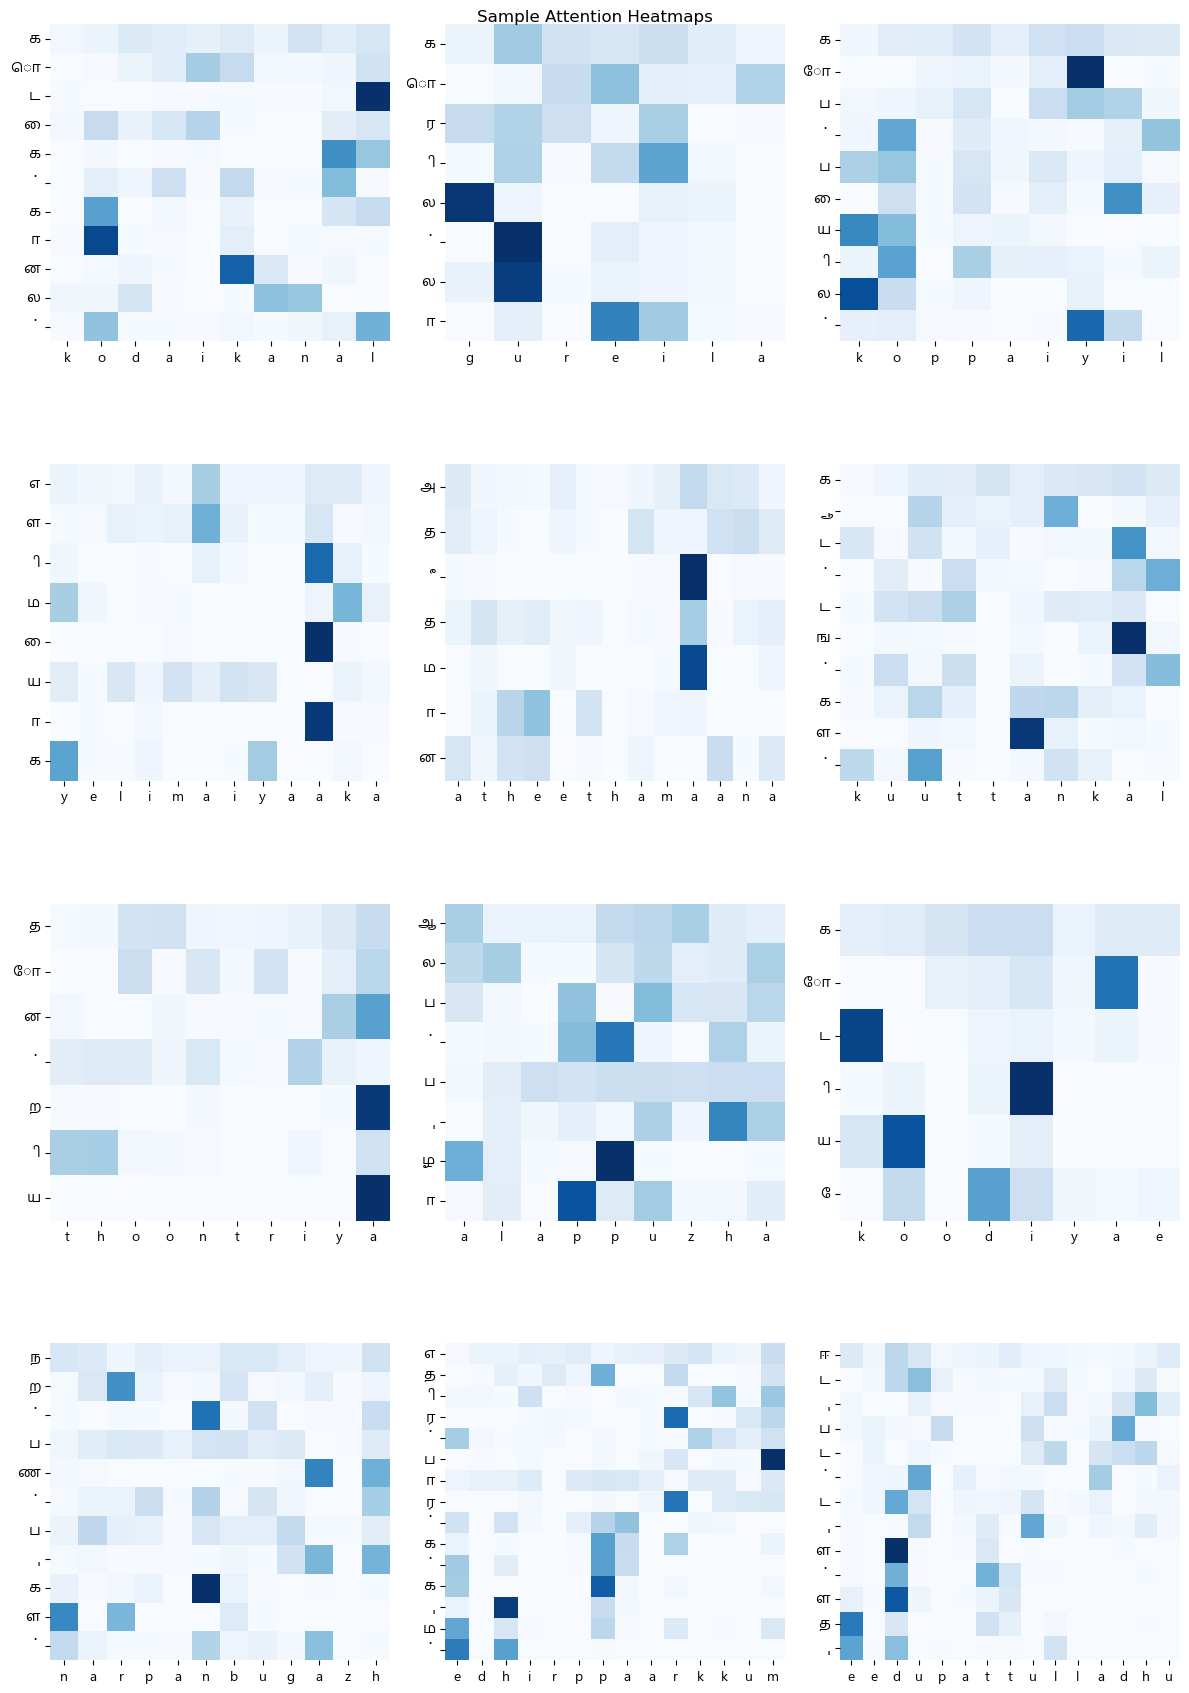

In [21]:
sample_test_data = data.load_data("test", batch_size=12, padding_upper_bound=MAX_LEN, num_batches=1)
src, tar = sample_test_data[0]
src, tar = src.to(device), tar.to(device)

src_strings = data.tensor_to_string(src, string_type="source")
tar_strings = data.tensor_to_string(tar, string_type="target")
attn = attn_model.get_attention_matrix(src, tar)

fig = plot_attention_heatmaps(attn, src_strings, tar_strings)

## Testing

In [20]:
test_loss, test_acc = attn_model.calc_evaluation_metrics(test,path_to_store_predictions="predictions_attention/results.csv")
print(f"Test dataset loss: {test_loss:.2f} \nAccuracy: {test_acc}")

Test dataset loss: 1.29 
Accuracy: 50.146484375


## Correct vs Incorrect Predictions

In [15]:
res_df = pd.read_csv("predictions_attention/results.csv")
correct_predictions_df = res_df[res_df['PredictionStatus']=='correct']
correct_predictions_df.head(10)

,Source,Target,Predicted,PredictionStatus
2,vazhakkukalaiyum,வழக்குகளையும்,வழக்குகளையும்,correct
5,visaigalai,விசைகளை,விசைகளை,correct
6,pathineazhaam,பதினேழாம்,பதினேழாம்,correct
7,thaniththanik,தனித்தனிக்,தனித்தனிக்,correct
10,kidaikkak,கிடைக்கக்,கிடைக்கக்,correct
17,avathaarangkal,அவதாரங்கள்,அவதாரங்கள்,correct
18,urudhiyaana,உறுதியான,உறுதியான,correct
20,siraikku,சிறைக்கு,சிறைக்கு,correct
21,binvaangkinaar,பின்வாங்கினார்,பின்வாங்கினார்,correct
24,payanpaduththavillai,பயன்படுத்தவில்லை,பயன்படுத்தவில்லை,correct


In [16]:
incorrect_predictions_df = res_df[res_df['PredictionStatus']=='wrong']
incorrect_predictions_df.head(20)

,Source,Target,Predicted,PredictionStatus
0,maaraaka,மாறாக,மாராக,wrong
1,wabag,வபாக்,வாபாக்,wrong
3,puunakariyil,பூநகரியில்,புனாகரியில்,wrong
4,carbogen,கார்போஜென்,கார்போகென்,wrong
8,velichchathirkum,வெளிச்சத்திற்கும்,வெளிச்சதிற்கும்,wrong
9,magizhndhiruppargal,மகிழ்ந்திருப்பார்கள்,மகிழ்ந்திருப்பர்கள்,wrong
11,texas,டெக்சாஸ்,டெக்காஸ்,wrong
12,seamec,ஸீமெக்,சீமேக்,wrong
13,japan,ஜப்பான்,ஜபான்,wrong
14,oill,ஆயில்,ஒயில்ல்,wrong
